In [6]:
# Cell 1 — Imports
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [11]:
# Cell 2 — Paths & params
XSS_PAYLOAD_FILE = 'data/xsspayload.txt' # malicious XSS payloads (one per line)
GOOD_FILE = 'data/good.txt' # benign parameter values (one per line)
ARTIFACT_DIR = 'models_xss'
os.makedirs(ARTIFACT_DIR, exist_ok=True)
RANDOM_STATE = 42

In [12]:
# Cell 3 — Load raw data
def load_lines(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f'File not found: {path}')
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        return [ln.strip() for ln in f if ln.strip()]

malicious = load_lines(XSS_PAYLOAD_FILE)
benign = load_lines(GOOD_FILE)
print(f'Loaded {len(malicious)} malicious and {len(benign)} benign samples')

Loaded 1770 malicious and 15257 benign samples


In [13]:
# Cell 4 — Build DataFrame
df_m = pd.DataFrame({'text': malicious, 'label': 1})
df_b = pd.DataFrame({'text': benign, 'label': 0})
df = pd.concat([df_m, df_b], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [14]:
# Cell 5 — Basic cleaning
def normalize(s):
    s = str(s)
    s = s.strip()
    s = s.replace('\t',' ').replace('\n',' ')
    return s

df['text_clean'] = df['text'].apply(normalize)

# Inspect
print(df.label.value_counts())
df.head()

label
0    15257
1     1770
Name: count, dtype: int64


,text,label,text_clean
0,component,0,component
1,thermal,0,thermal
2,Raymond,0,Raymond
3,outtakes,0,outtakes
4,copy,0,copy


In [15]:
# Cell 6 — Train/test split
X = df['text_clean'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [16]:
# Cell 7 — Vectorization (char n-grams are useful for XSS patterns)
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,6), max_features=20000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print('Vectorized shapes:', X_train_vec.shape, X_test_vec.shape)

Vectorized shapes: (13621, 20000) (3406, 20000)


In [17]:
# Cell 8 — Decision Tree training (GridSearchCV)
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_params = {'max_depth':[10,20,40,None], 'min_samples_split':[2,5,10]}
gs_dt = GridSearchCV(dt, dt_params, cv=3, scoring='f1', n_jobs=-1)
print('Training Decision Tree...')
gs_dt.fit(X_train_vec, y_train)
best_dt = gs_dt.best_estimator_
print('Best DT params:', gs_dt.best_params_)

# Evaluate DT
y_pred_dt = best_dt.predict(X_test_vec)
print('\nDecision Tree Report:\n')
print(classification_report(y_test, y_pred_dt, digits=4))

# Save DT
joblib.dump(best_dt, os.path.join(ARTIFACT_DIR, 'decision_tree_xss.joblib'))

Training Decision Tree...
Best DT params: {'max_depth': 20, 'min_samples_split': 2}

Decision Tree Report:

              precision    recall  f1-score   support

           0     0.9993    1.0000    0.9997      3052
           1     1.0000    0.9944    0.9972       354

    accuracy                         0.9994      3406
   macro avg     0.9997    0.9972    0.9984      3406
weighted avg     0.9994    0.9994    0.9994      3406



['models_xss/decision_tree_xss.joblib']

In [18]:
# Cell 9 — Random Forest (GridSearchCV)
rf = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE)
rf_params = {'n_estimators':[100,200], 'max_depth':[20,40,None], 'min_samples_split':[2,5]}
gs_rf = GridSearchCV(rf, rf_params, cv=3, scoring='f1', n_jobs=-1)
print('Training Random Forest...')
gs_rf.fit(X_train_vec, y_train)
best_rf = gs_rf.best_estimator_
print('Best RF params:', gs_rf.best_params_)

# Evaluate RF
y_pred_rf = best_rf.predict(X_test_vec)
print('\nRandom Forest Report:\n')
print(classification_report(y_test, y_pred_rf, digits=4))

# Save RF and vectorizer
joblib.dump(best_rf, os.path.join(ARTIFACT_DIR, 'random_forest_xss.joblib'))
joblib.dump(vectorizer, os.path.join(ARTIFACT_DIR, 'tfidf_vectorizer_xss.joblib'))

Training Random Forest...
Best RF params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Random Forest Report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3052
           1     1.0000    1.0000    1.0000       354

    accuracy                         1.0000      3406
   macro avg     1.0000    1.0000    1.0000      3406
weighted avg     1.0000    1.0000    1.0000      3406



['models_xss/tfidf_vectorizer_xss.joblib']

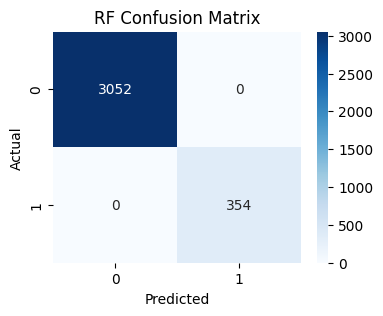

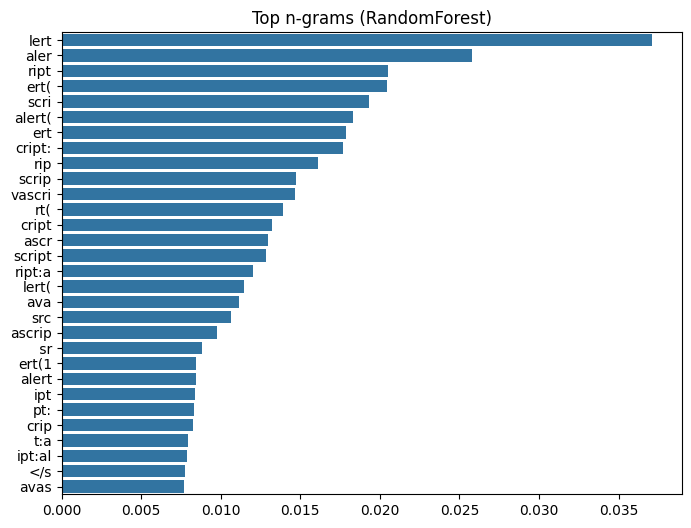

In [19]:
# Cell 10 — Confusion matrix and feature importance
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RF Confusion Matrix')
plt.show()

# Top n-grams
try:
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[::-1][:30]
    features = np.array(vectorizer.get_feature_names_out())
    top_feats = features[indices]
    top_imps = importances[indices]
    plt.figure(figsize=(8,6))
    sns.barplot(x=top_imps, y=top_feats)
    plt.title('Top n-grams (RandomForest)')
    plt.show()
except Exception as e:
    print('Feature importances not available:', e)

In [20]:
# Cell 11 — Save evaluation summary
with open(os.path.join(ARTIFACT_DIR, 'evaluation_summary.txt'), 'w') as f:
    f.write('Decision Tree:\n')
    f.write(classification_report(y_test, y_pred_dt, digits=4))
    f.write('\nRandom Forest:\n')
    f.write(classification_report(y_test, y_pred_rf, digits=4))

print('Artifacts saved to', ARTIFACT_DIR)

Artifacts saved to models_xss


In [21]:
# Cell 12 — Quick usage snippet
print('\nExample usage (python):')
print("from sklearn.feature_extraction.text import TfidfVectorizer")
print("import joblib")
print(f"vec = joblib.load('{ARTIFACT_DIR}/tfidf_vectorizer_xss.joblib')")
print(f"model = joblib.load('{ARTIFACT_DIR}/random_forest_xss.joblib')")
print("vec.transform(['<script>alert(1)</script>']) -> model.predict_proba(...)")


Example usage (python):
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
vec = joblib.load('models_xss/tfidf_vectorizer_xss.joblib')
model = joblib.load('models_xss/random_forest_xss.joblib')
vec.transform(['<script>alert(1)</script>']) -> model.predict_proba(...)
